# A/B–тестирование

В ходе тестирования одной гипотезы целевой группе была предложена новая механика оплаты услуг на сайте, у контрольной группы оставалась базовая механика.  
Необходимо проанализировать итоги эксперимента и сделать вывод, стоит ли запускать новую механику оплаты на всех пользователей.  

В качестве входных данных имеется 3 csv-файла:
- groups.csv : файл с информацией о принадлежности пользователя к контрольной или экспериментальной группе (А – контроль, B – целевая группа)
- active_studs.csv : файл с информацией о пользователях, которые зашли на платформу в дни проведения эксперимента.
- checks.csv : файл с информацией об оплатах пользователей в дни проведения эксперимента.

#### Вопросы  
- На какие метрики Вы смотрите в ходе анализа и почему?
- Имеются ли различия в показателях и с чем они могут быть связаны?
- Являются ли эти различия статистически значимыми?
- Стоит ли запускать новую механику на всех пользователей?  


#### Решение


#### ШАГ 1: Подготовка к анализу
- импортируем библиотеки, 
- загружаем данные,
- проверяем данные,
- формируем план анализа.

In [1]:
# Загружаем библеотики.

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.stats import t
from math import sqrt
import seaborn as sns


In [2]:
# Читаем данные:

# принадлежность пользователя к контрольной или экспериментальной группе (А – контроль, B – целевая группа).
df_groups = pd.read_csv('https://raw.githubusercontent.com/zhukov-analyst/portfolio/main/ab-test/data/groups.csv', sep=';')

# пользователи, которые зашли на платформу в дни проведения эксперимента.
df_active_studs = pd.read_csv('https://raw.githubusercontent.com/zhukov-analyst/portfolio/main/ab-test/data/active_studs.csv')

# оплата пользователей в дни проведения эксперимента.
df_checks = pd.read_csv('https://raw.githubusercontent.com/zhukov-analyst/portfolio/main/ab-test/data/checks.csv', sep=';')

In [3]:
# Проверяем данные на анамалии и изучаем для выстраивания дальнейшей логики работы.

def describe_data(df):
    display(df.head(10))
    print('---------------------------------------------------')
    print(df.info())
    print('---------------------------------------------------')
    print(df.describe())
    print('---------------------------------------------------')
    print('Пропуски:')
    print(df.isna().sum())
    print('---------------------------------------------------')
    print('Дубликаты:', df.duplicated().sum())
    print()

describe_data(df_groups)
describe_data(df_active_studs)
describe_data(df_checks)

,id,grp
0,1206794,B
1,331024,B
2,1733498,A
3,161574,B
4,168443,B
5,172064,A
6,176564,B
7,199038,B
8,214114,A
9,227004,A


---------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74576 entries, 0 to 74575
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      74576 non-null  int64 
 1   grp     74576 non-null  object
dtypes: int64(1), object(1)
memory usage: 1.1+ MB
None
---------------------------------------------------
                 id
count  7.457600e+04
mean   2.165617e+06
std    2.786959e+06
min    1.489000e+03
25%    9.197188e+05
50%    1.669752e+06
75%    3.328121e+06
max    2.010677e+08
---------------------------------------------------
Пропуски:
id     0
grp    0
dtype: int64
---------------------------------------------------
Дубликаты: 0



,student_id
0,581585
1,5723133
2,3276743
3,4238589
4,4475369
5,5481015
6,1353433
7,1394612
8,1170611
9,491277


---------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8341 entries, 0 to 8340
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   student_id  8341 non-null   int64
dtypes: int64(1)
memory usage: 65.3 KB
None
---------------------------------------------------
         student_id
count  8.341000e+03
mean   2.448547e+06
std    1.564978e+06
min    1.627000e+03
25%    1.118405e+06
50%    2.094192e+06
75%    3.638877e+06
max    5.951797e+06
---------------------------------------------------
Пропуски:
student_id    0
dtype: int64
---------------------------------------------------
Дубликаты: 0



,student_id,rev
0,1627,990.0
1,3185,690.0
2,25973,690.0
3,26280,690.0
4,100300,990.0
5,100645,630.0
6,102534,580.0
7,106837,290.0
8,108270,290.0
9,114366,690.0


---------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541 entries, 0 to 540
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   student_id  541 non-null    int64  
 1   rev         541 non-null    float64
dtypes: float64(1), int64(1)
memory usage: 8.6 KB
None
---------------------------------------------------
         student_id          rev
count  5.410000e+02   541.000000
mean   2.514772e+06  1059.752317
std    1.726839e+06   762.712359
min    1.627000e+03   199.000000
25%    9.871290e+05   290.000000
50%    2.526021e+06   840.000000
75%    3.993249e+06  1900.000000
max    5.740903e+06  4650.000000
---------------------------------------------------
Пропуски:
student_id    0
rev           0
dtype: int64
---------------------------------------------------
Дубликаты: 0



**Данные**  
С данными всё поряке. Пропусков нет. Все форматы данных соответствуют содержанию.  
Можно работать дальше. 


**План анализа**

_Выборка_  
В начале небходимо из имеющихся данных сформировать выборку исследования.  

Из всей совокупности размеченных пользователей мы имеем информацию о активных пользователях в дни эксперемента и о совершавших оплату.  
Для пользователей совершивших оплату мы знаем величину денежной транзакции.  


Таким образом совокупно имеется четыре сегмента:  

<table align="left">
	<tr>
		<th></th>
        <th>Группа A</th>
		<th>Группа B</th>
 	</tr>
    <tr>
		<th>Оплата есть</th>
		<th>seg №1</th>
        <th>seg №2</th>
 	</tr>
 	<tr>
		<th>Оплаты нет</th>
		<th>seg №3</th>
        <th>seg №4</th>
 	</tr>

</table> 


_Метрика_  
Основной метрикой анализа является величина денежной транзакции в контрольной и эксперементальной группах.
Дополнительно возможно оценить соотношение групп пользователей к факту оплаты.

_Инструмент_  
После изучения данных можно будет выбрать подходящий метод анализа.


#### ШАГ 2: Готовим выборку пользователей

На основе таблицы всех активных пользователей (active_studs) добавим информацию об оплате (checks) и о сегментации на группы (groups).

In [4]:
# Подготавливаем таблицы для объединения.
# Переименовываем название столбца в groups.

df_groups = df_groups.rename(columns = {'id':'student_id'})
df_groups.head()


,student_id,grp
0,1206794,B
1,331024,B
2,1733498,A
3,161574,B
4,168443,B


In [5]:
# Поочередно объединяем таблицы, следуя следующей логике:
# active_studs LEFT JOIN checks - получаем общюю совокупность активных пользователей с информацией о оплате;
# INNER JOIN groups - дополняем данные информацией о принадлежности к контрольной или эксперементальной группе.

df_total = pd.merge(df_active_studs, df_checks, how = 'left', on = ('student_id'))
df_total = pd.merge(df_total, df_groups, how = 'inner', on = ('student_id'))

df_total

,student_id,rev,grp
0,581585,NaN,A
1,5723133,NaN,A
2,3276743,NaN,B
3,4238589,NaN,A
4,4475369,NaN,B
...,...,...,...
8336,1794344,NaN,B
8337,296883,NaN,B
8338,3598448,NaN,B
8339,3610547,290.0,B


In [6]:
# Добавим ещё столбец с логической отметкой о факте оплаты.  
# Он может понадобиться на этапе построения дополнительных графиков.

df_total['rev_2'] = np.where(df_total['rev'] > 0, 1, 0)
df_total['rev_2'] = df_total['rev_2'].astype('bool')

# Добавим отдельно столбцы для группы A и B для простоты построения графиков.
df_total['A'] = np.where(df_total['grp'] == 'A', df_total['rev']*1.0, np.nan)
df_total['B'] = np.where(df_total['grp'] == 'B', df_total['rev']*1.0, np.nan)

df_total

,student_id,rev,grp,rev_2,A,B
0,581585,NaN,A,False,NaN,NaN
1,5723133,NaN,A,False,NaN,NaN
2,3276743,NaN,B,False,NaN,NaN
3,4238589,NaN,A,False,NaN,NaN
4,4475369,NaN,B,False,NaN,NaN
...,...,...,...,...,...,...
8336,1794344,NaN,B,False,NaN,NaN
8337,296883,NaN,B,False,NaN,NaN
8338,3598448,NaN,B,False,NaN,NaN
8339,3610547,290.0,B,True,NaN,290.0


In [7]:
# Проверяем правильность созданной таблицы.

df_total.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8341 entries, 0 to 8340
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   student_id  8341 non-null   int64  
 1   rev         392 non-null    float64
 2   grp         8341 non-null   object 
 3   rev_2       8341 non-null   bool   
 4   A           78 non-null     float64
 5   B           314 non-null    float64
dtypes: bool(1), float64(3), int64(1), object(1)
memory usage: 399.1+ KB


Всё готово для анализа.

#### ШАГ 3: Описательный анализ данных.


In [8]:
# Посмотрим таблицу с общей статистической информацией.

df_total_stat = df_total.describe()
df_total_stat

,student_id,rev,A,B
count,8.341000e+03,392.000000,78.000000,314.000000
mean,2.448547e+06,1193.352050,933.589744,1257.878992
std,1.564978e+06,827.136901,919.932711,790.864254
min,1.627000e+03,199.000000,199.000000,199.000000
25%,1.118405e+06,290.000000,290.000000,511.750000
50%,2.094192e+06,990.000000,585.000000,1140.000000
75%,3.638877e+06,1900.000000,1114.750000,1900.000000
max,5.951797e+06,4650.000000,3660.000000,4650.000000


**Промежуточные наблюдения**  

Из 8341 активных пользователей только 392 совершили оплату в дни проведения эксперемента - это меньше 5%.  
Неизвестно является ли это нормальным коэффициентом конверсии, из имеющихся данных нельзя сделать выводы.  

Всего в эксперементе приняли участие 392 пользователя в соотношении 80% B-группа и 20% A-группа.  

По данным о средних и стандартных отклонениях можно наблюдать видимые различия.  
Для статистической проверки необходимо проверить данные на нормальность распредления и выбрать статистический инструмент. 

В данных скорее всего отсутсвуют серьезные выбросы, но всё равно проверим с помощью boxplot.

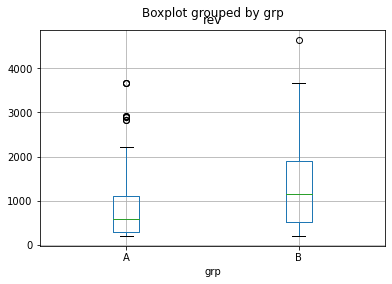

95й и 99й перцентили: [2220. 3660.]


In [9]:
# Проверяем на выбросы.

# Изучаем boxplot.

df_total.boxplot(column='rev',by='grp', showfliers=True)
plt.show()


# Смотрим на крайние вверхние значения.

print('95й и 99й перцентили:', np.nanpercentile(df_total[['rev']], [95, 99]))


Несколько выбросов всё же имеются.  
Больше их у группы A, но возможно это имеет объяснение.

В целом, менее 5% пользователей совершают оплату выше 2220, менее 1% выше 3660.

Далее изучим распредление выборок.

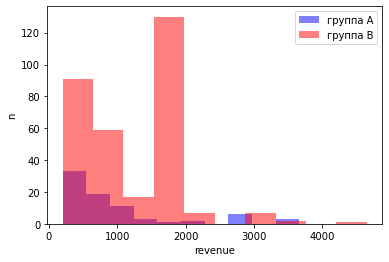

In [10]:
# Проверим распредление выборок на нормальность.

a = df_total['A']
b = df_total['B']

plt.hist(a, bins=10, edgecolor='None', alpha = 0.5, color= 'b', label = 'группа A')
plt.hist(b, bins=10, edgecolor='None', alpha = 0.5, color= 'r', label = 'группа B')

plt.ylabel('n')
plt.xlabel('revenue')
plt.legend()
plt.show()

Распределение данных не похоже на нормальное.  
Для обеих выборок свойственна правостороняя ассиметрия в сторону низкой стоимости.  
Однако есть небольшой "горб" ближе к 3000 - видимо, сегмент премиальных продуктов.

Ярко выделяется "свеча" в группе B в районе 2000 - возможно это связано с изменением механики оплаты или же это иное проявление маркетинговой активности. В любом случае, делать выводы только на основании гистограммы некорретно, т.к. данные о выборках представлены в разном объеме (A = 78, B = 314 наблюдений).  

#### ШАГ 4: Статистическая проверка гипотезы.



Для проверки наличия статистических различий между выборками A и B следует воспользоваться t-критерием Стьюдента для несвязных выборок - посколько данные непрерывные количественные, выборка достаточная.

Нулевая гипотеза: revenue в группах A и B одинаковая.  
Альтернативная гипотеза: revenue в группах A и B существенно различается.  

Уровень статистической значимости примем за 0.05.


In [12]:
# t-критерием Стьюдента

# Задаём входные данные.
mean_A = df_total_stat['A']['mean']
mean_B = df_total_stat['B']['mean']

sd_A = df_total_stat['A']['std']
sd_B = df_total_stat['B']['std']

n_A = df_total_stat['A']['count']
n_B = df_total_stat['B']['count']

# Расчитываем SE
SE = sqrt(((sd_A ** 2) / n_A) + ((sd_B ** 2) / n_B))

# Расчитываем число степеней свободы
df = n_A + n_B - 2

# Расчитывает t-критерий Стьюдента
t_value = (mean_A - mean_B) / SE

# Расчитвает p-критерий значимости
p_score = stats.t.sf(np.abs(t_value), df)*2

print(f'p_score = ', p_score)
if p_score >= 0.05:
    print('Мы НЕ можем отклонить нулевую гипотезу')
else:
    print('Мы можем отклонить нулевую гипотезу')



p_score =  0.0044409391801694615
Мы можем отклонить нулевую гипотезу


**Вывод**  

Предварительная оценка данных показала схожесь общего паттерна распредления revenue в контрольной и тестовой группе, с ярким отклонением эксперементальной группы возле одного конкретного числа (2000). Это может быть связано с особенностями проведения A/B-теста или иной маркетинговой активностью - необходимо разбираться подробнее.

Помимо этой яркой особенности, никаких других серьезных анамалий не обнаружено.


Статистические анализ t-критерием Стьюдента потвердил значимость различий показателя revenue между двумя группами выборок.  
Эксперементальная группа B показала лучший результат (mean 1257) по сравнению с контрольной группой (mean 933).
Можно рекомендовать внедрение новой системы оплаты.